# SNR as a distingusher

This is a companion notebook for the tutorial on using SNR as distinguisher. For our traces, we have cloned the TinyAES implementation from this repository https://github.com/kokke/tiny-AES-c/ and we loaded the firmware on an ARM Cortex M0, which was modified for the collection of traces.
If you want to follow along, download the set of traces from here https://zenodo.org/record/4742593#.YK8drmYzYUo.


In [1]:
import scipy.io
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #progress bar for visualization of progress

After loading the relevant libraries, lets have a look at the datafiles. We have the following files:
- `overview_trace.npy`, the trace is measured while the board is performing a full AES encryption. 
- `trace_set.npy` , is the trace set file, with a given `number_of_traces`, captured from the oscilloscope. 
It captures roughly the first round of execution (it contains samples $10000-25000$ from the overview trace). Each trace has `number_of_samples` samples. 
- `plaintex.txt`, contains the plaintexts which are encrypted by the algorithm. One plaintext corresponds to one trace (they are provided in order).

Let's load these datafiles and figure out how many traces we have in the trace set file and how many samples each trace has. 


In [2]:
traces = np.load("trace_set_10k.npy")

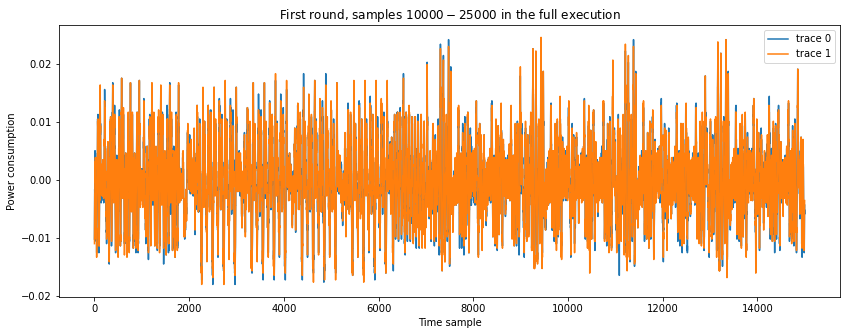

In [3]:
plt.figure(figsize=(14,5))
plt.plot(traces[0,:], label='trace 0')
plt.plot(traces[1,:], label='trace 1')
plt.title('First round, samples $10000-25000$ in the full execution')
plt.xlabel('Time sample')
plt.ylabel('Power consumption')
plt.legend()
plt.savefig('first_round.png')


In [4]:
number_of_traces=len(traces)
print('Number of traces:', number_of_traces)
number_of_samples=len(traces[0])
print('Number of samples:', number_of_samples)

Number of traces: 10000
Number of samples: 15000


It also seems that the traces are pretty well aligned, so smooth sailing. We are provided with the AES S-box table, which we will use during the attack. To refresh your memory on the use of the S-box, please refer to this article https://en.wikipedia.org/wiki/Rijndael_S-box. 

In [5]:
sbox = [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
            0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
            0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
            0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
            0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
            0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
            0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
            0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
            0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
            0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
            0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
            0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
            0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
            0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
            0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
            0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
            0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
            0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
            0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
            0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
            0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
            0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
            0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
            0x54, 0xbb, 0x16]

Read the plaintext file, we need this to compute the LSB leakage model. 

In [6]:
plaintext = np.zeros(shape=(number_of_traces, 16))

filename="plaintext_new.txt"
with open(filename) as f:
    content = f.readlines()

content = [x.strip() for x in content] 
plaintext = np.array([bytearray.fromhex(c) for c in content])


Some definitions of variables to help us decypher the code:

- `TARGET_BYTE`, the attack is performed using divide-and-conquer approach, one byte at a time. This variable represents the key byte we are recovering. 
- `BYTE_COMBINATIONS`, is a constant which represents the number of hypothesis, `key_hypothesis`, we make for determining the correct value of `TARGET_BYTE`
-`prediction_matrix`, for each plaintext(=`number_of_traces`), and for each `key_hypothesis` compute the S-box out for `TARGET_BYTE`


In [7]:
def prepare_data(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = the leakage model of the target intermediate value
    
    returns a dictionary of the form
       'label_value': list of traces associated with 'label_value'
    """
   
    labels=np.unique(labels_set)
    #initialize the dictionary
    d={}
    for i in labels:
         d[i]=[]
    for count, label in enumerate(labels_set):
        d[label].append(trace_set[count])
    return d

def return_snr_trace(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = a set of labels of the same lenght as trace_set
    
    returns a dictionary of the form
       'label_value': mean_sample trace with 'label_value'
    """
    mean_trace={}
    signal_trace=[]
    noise_trace=[]
    labels=np.unique(labels_set) #determine the set of unique values for the leakage model
    grouped_traces=prepare_data(trace_set, labels_set) # we group the traces according to the label

    for i in labels:
        mean_trace[i]=np.mean(grouped_traces[i], axis=0)
        signal_trace.append(mean_trace[i]) 
    #compute the noise trace  
    for i in labels:
        for trace in grouped_traces[i]:
            noise_trace.append(trace-mean_trace[i])
    var_noise=np.var(noise_trace, axis=0)
    var_signal=np.var(signal_trace, axis=0)
    snr_trace=var_signal/var_noise  
    return snr_trace, var_noise, var_signal   



## Lets pick our target intermediate value

In [8]:
TARGET_BYTE=0
CORRECT_BYTE_VALUE=0xCA

## Leakage model

In [18]:
def HW(x):
    return sum([x&(1<<i)>0 for i in range(32)])

BYTE_COMBINATIONS=256 # the number of possible values for the target byte is 2^8
prediction_matrix = np.zeros(shape=(number_of_traces, BYTE_COMBINATIONS), dtype=int)

for i in tqdm(range(0, number_of_traces)):
    for key_hypothesis in range(0, BYTE_COMBINATIONS):      
        prediction_matrix[i][key_hypothesis] = HW(sbox[key_hypothesis ^ int(plaintext[i][TARGET_BYTE])])
print('I am done!')


100%|██████████| 10000/10000 [00:12<00:00, 802.18it/s]

I am done!


## SNR as Distingusher

Here we compute one SNR trace for each of the 256 possible values of `TARGET_BYTE`\
CAUTION: patience required in the next step! It takes a few minutes to compute all SNR traces.

In [10]:
SNR_traces= np.zeros(shape=(BYTE_COMBINATIONS,number_of_samples))
for i in tqdm(range(0, BYTE_COMBINATIONS)):
    SNR_traces[i],_,_=return_snr_trace(traces, prediction_matrix[:,i])

100%|██████████| 256/256 [10:04<00:00,  2.36s/it]


Now lets check what is the value of the key candidate corresponding to the highest SNR value. We know that we have the correct key candidate if the correct byte value is `0xca`.

In [21]:
max_value = 0
correct_byte = 0
for j in range(BYTE_COMBINATIONS):
     if max_value < SNR_traces[j].max():
            second_value=correct_byte
            max_value= SNR_traces[j].max()
            correct_byte=j
    
print('Correct hypothesis: ',correct_byte)
print('Correct byte value: ',hex(correct_byte))

Correct hypothesis:  202
Correct byte value:  0xca


Yay! SNR does output the correct key candidate. Now lets visualize the results and plot the SNR traces. We will use color red for the corect key candidate and black for the other 255 incorrect values. 

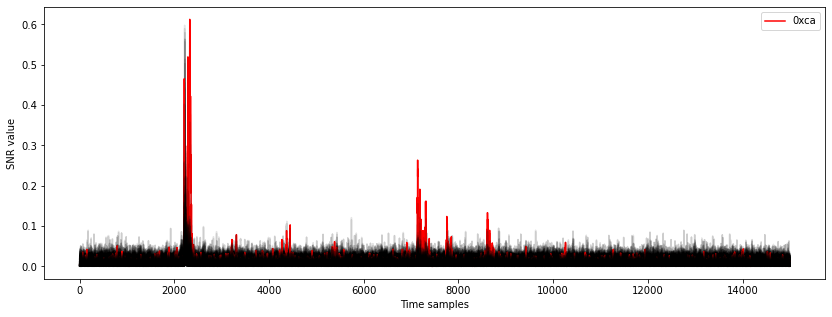

In [22]:
plt.figure(figsize=(14,5))
for j in range(BYTE_COMBINATIONS):
    if j == correct_byte: 
        plt.plot(SNR_traces[j], color='r',label=hex(correct_byte))
    else:
        plt.plot(SNR_traces[j], color='k',alpha=0.1)

plt.ylabel('SNR value')
plt.xlabel('Time samples')
plt.legend()
plt.savefig('SNR_10k')
plt.show()

## Is SNR a good distinguisher?

Thats a very good question! Lets take a closer look at the difference between the first and second key candidates.

In [23]:
max_value = 0
second_value=0
correct_byte = 0
for j in range(BYTE_COMBINATIONS):
     if max_value < SNR_traces[j].max():
            second_value=correct_byte
            max_value= SNR_traces[j].max()
            correct_byte=j
    
print('Correct hypothesis: ',correct_byte)
print('Correct byte value: ',hex(correct_byte))
print('Second candidate:', second_value)
print('Correct byte value: ',hex(second_value))

Correct hypothesis:  202
Correct byte value:  0xca
Second candidate: 153
Correct byte value:  0x99


In [24]:
def return_max_SNR(SNR_list):
    temp=list(enumerate(SNR_list))
    for elem in temp:
        if max(SNR_list)==elem[1]:
            return elem[0],elem[1]

print(return_max_SNR(SNR_traces[202]))
print(return_max_SNR(SNR_traces[153]))

(2324, 0.6125719952460539)
(2216, 0.597986180069666)


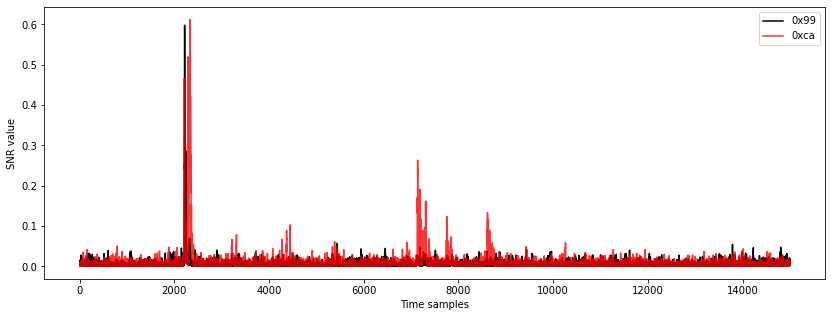

In [26]:
plt.figure(figsize=(14,5))
plt.plot(SNR_traces[153], color='k',alpha=1,  label=hex(second_value))
plt.plot(SNR_traces[202], color='r',alpha=0.8,label=hex(correct_byte))

plt.ylabel('SNR value')
plt.xlabel('Time samples')
plt.legend()
plt.savefig('SNR_top_2')